# LE model without time as fixed-effect

In [40]:
# libraries
library(rstan)
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())
library(brms)
library(loo)
library(haven)
library(sdazar)
library(data.table)
library(MASS)

library(bayesplot)
library(forcats)
library(ggplot2)
library(patchwork)
options(repr.plot.width = 5, repr.plot.height = 3)
source('Rutils/functions.R')

In [41]:
# load data

df = data.table(read_stata('../data/LA_uncertainty.dta'))

df = df[, .(ctry, year, gdp_pc, median)]
setnames(df, c('gdp_pc', 'median'), c('gdp', 'le'))
df = df[complete.cases(df)]

df[, le_log := scale(log(le), scale=FALSE)]
df[, gdp_log := scale(log(gdp), scale=FALSE)]
df[, year_log := scale(log(year), scale=FALSE)]
df[, year_c := scale(year, scale=FALSE)]

In [42]:
summary(df$year_log)

      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-0.0327240 -0.0118899  0.0009144  0.0000000  0.0135568  0.0235568 

In [43]:
# year recode based on the criteria proposed by Alberto
df[year<1950, gyear:=1]
df[year>=1950 & year<1970, gyear:=2]
df[year>=1970 & year<1990, gyear:=3]
df[year>=1990, gyear :=4]

In [44]:
table(df$gyear, useNA='ifany') # discrete groups of year


  1   2   3   4 
103  76  76  88 

I use only the Weibull transformation, the Gompertz transformation doesn't look good!

In [45]:
# transform variable: weibull
df[, y := le/max(le+1.05), by = ctry] # by country, really!!!
df[, wy := log(-log(1-y))]
max_le = df[, .(max_le = max(le+1.05)), by = ctry]

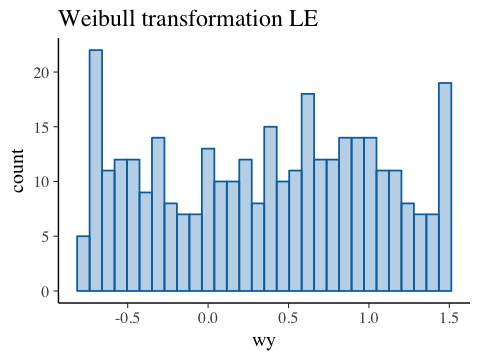

In [323]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(df, aes(wy)) + geom_histogram(bins=30, color='#0072B2', fill='#0072B2', alpha=0.3) +
    labs(title='Weibull transformation LE')

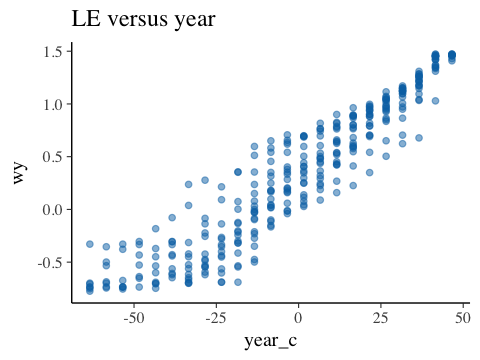

In [303]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(df, aes(y=wy, x=year_c)) + geom_point(alpha=0.5, color='#0072B2') + labs(title='LE versus year')

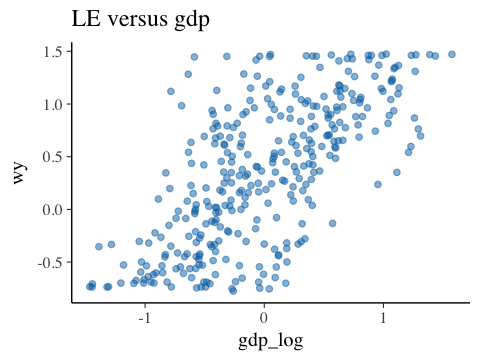

In [306]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(df, aes(y=wy, x=gdp_log)) + geom_point(alpha=0.5, color='#0072B2') + labs(title='LE versus gdp')

### Example 1

- I create a variable resulting from the combination of country and year
- I specify country-year random intercept and GDP random coefficient

In [205]:
df[, ctry_year := 10000 * gyear + ctry]
table(df$ctry_year)


12020 12060 12070 12120 12130 12140 12150 12190 12250 12280 12310 12340 12350 
   10     1    10    10     9     6     6     4     6     4    10     2     1 
12370 12460 12470 22020 22060 22070 22120 22130 22140 22150 22170 22180 22190 
   10    10     4     4     4     4     4     4     4     4     4     4     4 
22250 22280 22310 22340 22350 22360 22370 22460 22470 32020 32060 32070 32120 
    4     4     4     4     4     4     4     4     4     4     4     4     4 
32130 32140 32150 32170 32180 32190 32250 32280 32310 32340 32350 32360 32370 
    4     4     4     4     4     4     4     4     4     4     4     4     4 
32460 32470 42020 42060 42070 42120 42130 42140 42150 42170 42180 42190 42250 
    4     4     5     4     5     5     5     5     4     5     5     4     5 
42280 42310 42340 42350 42360 42370 42460 42470 
    4     5     4     4     4     5     5     5 

In [231]:
w1 = brm(formula = wy ~ 1 + gdp_log +  (gdp_log | ctry_year), 
    data = df, control=list(adapt_delta=0.85))

Compiling the C++ model
Start sampling


In [233]:
summary(w1)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: wy ~ 1 + gdp_log + (gdp_log | ctry_year) 
   Data: df (Number of observations: 343) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~ctry_year (Number of levels: 73) 
                       Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)              0.47      0.04     0.39     0.57        986 1.00
sd(gdp_log)                0.25      0.08     0.06     0.40        343 1.01
cor(Intercept,gdp_log)     0.02      0.26    -0.47     0.55       2682 1.00

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept     0.40      0.06     0.29     0.52        647 1.01
gdp_log       0.74      0.06     0.61     0.87       1711 1.00

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sigma     0.15      0.01    

### Counterfactuals

In [311]:
# extract posterior samples of population-level effects 
samples <- posterior_samples(w1)

#### 1950

In [312]:
vars = c('b_Intercept', 'b_gdp_log', 'r_ctry_year[12020,Intercept]', 'r_ctry_year[12020,gdp_log]')
pd = data.table(samples[, vars])
nvars = c('int', 'b_gdp', 'i_ctry_year', 'gdp_ctry_year')
setnames(pd, names(pd), nvars)

In [313]:
gdp_value = df[ctry==2020 & year==1950, gdp_log]
le_obs = df[ctry==2020 & year==1950, le]
max_value_le = max_le[ctry==2020, max_le]

In [314]:
pd[, est := (int + i_ctry_year) + (b_gdp + gdp_ctry_year) * gdp_value][, le_pred := 
      get_orig_values_weibull(est, max_value_le)]

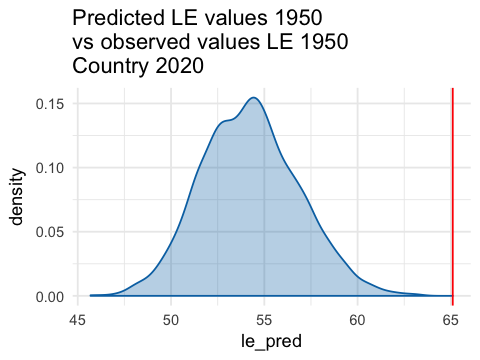

In [315]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(pd, aes(le_pred))  + geom_density(color='#0072B2', fill='#0072B2', alpha=0.3) + 
    geom_vline(xintercept = le_obs, color='red') + 
    labs(title='Predicted LE values 1950 \nvs observed values LE 1950\nCountry 2020') + 
    theme_minimal()

#### 1970

In [316]:
vars = c('b_Intercept', 'b_gdp_log', 'r_ctry_year[22020,Intercept]', 'r_ctry_year[22020,gdp_log]')
pd = data.table(samples[, vars])
nvars = c('int', 'b_gdp', 'i_ctry_year', 'gdp_ctry_year')
setnames(pd, names(pd), nvars)

gdp_value = df[ctry==2020 & year==1970, gdp_log]
le_obs = df[ctry==2020 & year==1970, le]

In [317]:
pd[, est := (int + i_ctry_year) + (b_gdp + gdp_ctry_year) * gdp_value][, le_pred := 
      get_orig_values_weibull(est, max_value)]

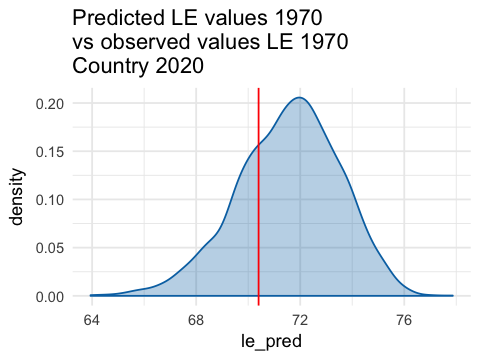

In [318]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(pd, aes(le_pred))  + geom_density(color='#0072B2', fill='#0072B2', alpha=0.3) +
    geom_vline(xintercept = le_obs, color='red') + 
    labs(title='Predicted LE values 1970 \nvs observed values LE 1970\nCountry 2020') + 
    theme_minimal()

#### 1990

In [319]:
vars = c('b_Intercept', 'b_gdp_log', 'r_ctry_year[32020,Intercept]', 'r_ctry_year[32020,gdp_log]')
pd = data.table(samples[, vars])
nvars = c('int', 'b_gdp', 'i_ctry_year', 'gdp_ctry_year')
setnames(pd, names(pd), nvars)

gdp_value = df[ctry==2020 & year==1990, gdp_log]
le_obs = df[ctry==2020 & year==1990, le]

In [320]:
pd[, est := (int + i_ctry_year) + (b_gdp + gdp_ctry_year) * gdp_value][, le_pred := 
      get_orig_values_weibull(est, max_value)]

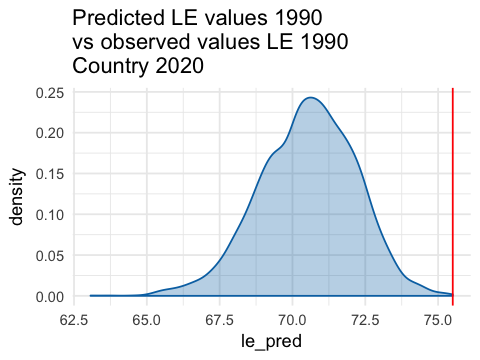

In [321]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(pd, aes(le_pred))  + geom_density(color='#0072B2', fill='#0072B2', alpha=0.3) +
    geom_vline(xintercept = le_obs, color='red') + 
    labs(title='Predicted LE values 1990 \nvs observed values LE 1990\nCountry 2020') + 
    theme_minimal()

### Goodness of fit

In [237]:
pred[,  `:=` (
    m = get_orig_values_weibull(m, max_le), 
    lo = get_orig_values_weibull(lo, max_le),
    hi = get_orig_values_weibull(hi, max_le)
    )]

In [238]:
countries = unique(df$ctry)

In [239]:
for (i in 1:length(countries)) {
    assign(paste0('plot', i), 
           ggplot(pred[ctry==countries[i]], aes(x=year, y=le)) + 
           geom_line(aes(y=m), color='#2b8cbe', size = 0.4)  +
           geom_ribbon(aes(ymin = lo, ymax = hi), fill = '#a6bddb', alpha=0.2)  + 
           geom_point(size=1, color='#e34a33', alpha=0.4) +
           labs(title=paste0('Country ', countries[i])) + 
           ylim(min(df$le)-25.0, max(df$le)+25.0) + 
           xlim(min(df$year), max(df$year)) + theme_minimal()
       )

}

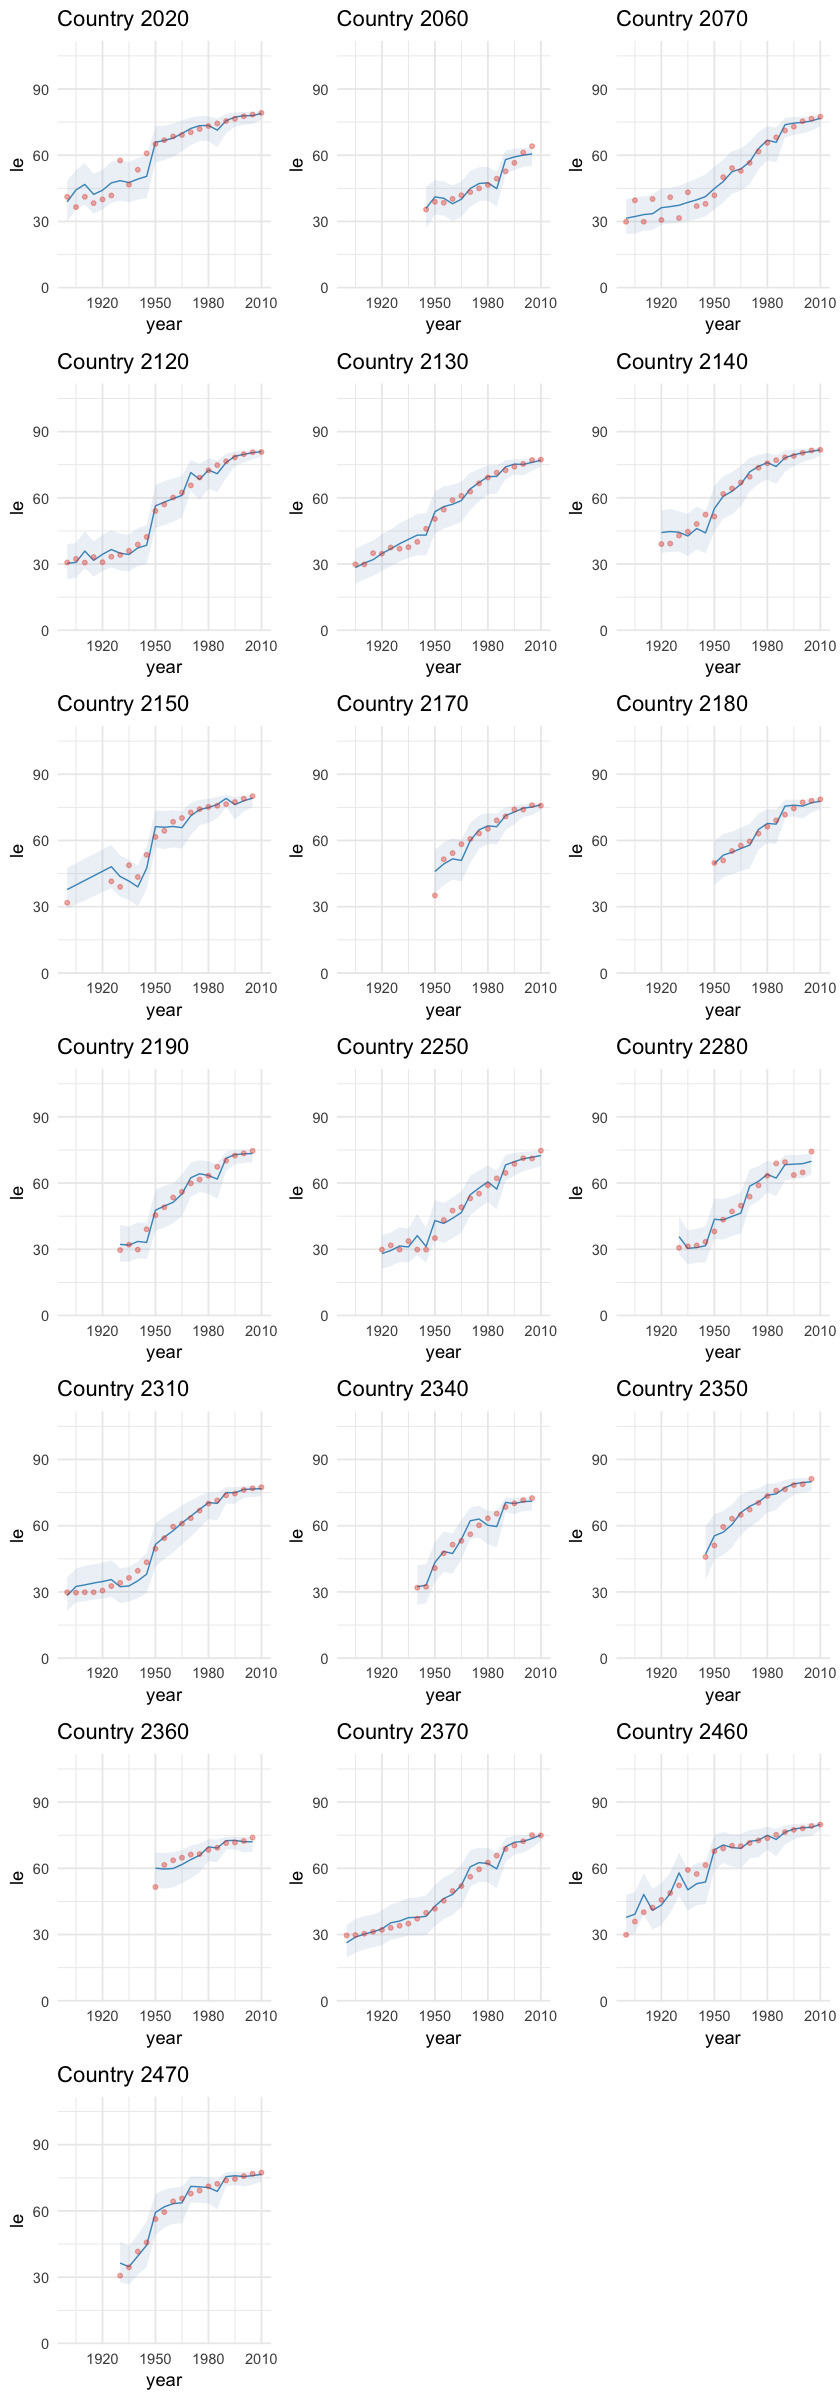

In [240]:
options(repr.plot.width = 7, repr.plot.height = 20)
eval(parse(text=paste0(paste0('plot', 1:length(countries), collapse='+'), '+plot_layout(ncol = 3)')))